In [15]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys as sys
import os as os
import geocluster as gc
from geocluster import plotting
from graph_library import generate_barbell, generate_tree, generate_clique_of_cliques, assign_graph_metadata
import networkx as nx
import scipy as sc
import pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FFMpegWriter
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clique of cliques

In [16]:
graph, pos = generate_clique_of_cliques(params = {'m':4, 'n': 3, 'L': 500, 'w':[1, 5, 10], 'p':[0.01, 0.1, 1]},
                                                  seed=0)
        
# initialise the code with parameters and graph 
graph.graph['name'] = 'clique_of_cliques'
graph = assign_graph_metadata(graph, pos=pos)

times = np.logspace(-4., 1., 30)
params = {'n_workers': 10, 'GPU': False, 'lambda': 0, 
          'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': True}

#Compute the OR curvatures
kappas = gc.compute_curvatures(graph, times, params, disable=True)

#Compute the zero-crossings of the edge curvatures
from scipy.interpolate import InterpolatedUnivariateSpline
roots = []
for j in range(kappas.shape[1]):
    f = InterpolatedUnivariateSpline(np.log10(times), kappas[:,j], k=3)
    _roots = f.roots()
    if len(_roots)==0:
        roots.append(-5) #these cross at -Infty, but set it to the lowest value
    if len(_roots)>0:
        roots.append(_roots[0])

# Curvature flow

In [ ]:
import matplotlib.cm as cmx
color = cmx.inferno(roots/np.max(roots))

#edge_vmin = -kappa_min
#kappa_min = abs(min(np.min(kappa), 0))
#kappa_max = max(np.max(kappa), 0)
#edge_vmax = 1.1 * kappa_max  # to avoid the not so visible bright yellow
#plt.plot(np.log10(times), kappas.T[10], c=color[10], lw=0.5)
#kappas.shape
kappas.T.shape

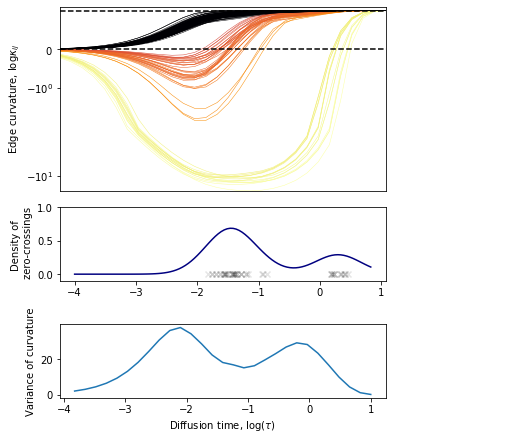

In [17]:
#Plot
fig = plotting.plot_edge_curvatures(times, kappas, edge_color = roots, ylog=True, filename = 'CoC') 
plotting.plot_graph_snapshots(graph, times, kappas, filename = 'CoC', disable=True)

# Zero-crossings

In [ ]:
fig = plotting.plot_graph(graph,roots,node_size=30,edge_width=2,figsize=(10, 7),color_map=1,label='Zero-crossing')

# Number of induced cycles

In [ ]:
def dfs(graph, start, end, limit=3):
    fringe = [(start, [])]
    while fringe:
        state, path = fringe.pop()
        if path and state == end:
            yield path
            continue
        if len(path)<limit:
            for next_state in graph[state]:
                if next_state in path:
                    continue
                fringe.append((next_state, path+[next_state]))  

def isCircular(arr1, arr2):
    if len(arr1) != len(arr2):
        return False

    str1 = ' '.join(map(str, arr1))
    str2 = ' '.join(map(str, arr2))
    if len(str1) != len(str2):
        return False

    return str1 in str2 + ' ' + str2 

def is_sub(sub, lst):
    ln = len(sub)
    for i in range(len(lst) - ln + 1):
        if all(sub[j] == lst[i+j] for j in range(ln)):
            return True
    return False

def induced_cycles(edge, graph, all_cycles):
    _count = 0
    for cycle in all_cycles: #loop cycles for each edge
        if is_sub(edge, cycle):
            #cumweight=0
            #for j in range(len(cycle)-1): #sum weight around cycle
            #    cumweight += graph[cycle[j]][cycle[j+1]]['weight']
            _count += 1#1/cumweight
    
    return _count        

def induced_loops_of_length_n(graph, n):
    #generate a dictionary of neighbours
    G = {}
    for i in graph.nodes:
        G[i] = [n for n in graph.neighbors(i)]

    #find all cycles up to length n
    #cycles = [[node]+path for node in G for path in dfs(G, node, node)]
    cycles = []
    for node in G:
        for path in dfs(G, node, node, limit=n+1):
            cycles.append([node] + path)

    #take only length n cycles        
    cycles = [cyc for cyc in cycles if len(cyc)==n+1]
    
    print(str(n) + ' - cycles found')
    #remove cyclically identical cycles
    #step = 0
    #while step<=len(cycles):
    #    for cyc2 in cycles[step+1:]:
    #        cyc1 = cycles[step]
    #        if isCircular(np.array(cyc1[:-1]), np.array(cyc2[:-1])):
    #            cycles.remove(cyc2)
    #    step+=1        
    
    #count how many cycles it is contained in
    
    from joblib import Parallel, delayed
    
    counts = [induced_cycles(list(edge), graph, cycles) for edge in graph.edges]
    #Parallel(n_jobs=16)(delayed(sqrt)(i ** 2) for i in range(10))
    
    #multiply by edge weight and discount cyclic/mirror symmetries 
    #weighted_counts = [counts[i]*graph[edge[0]][edge[1]]['weight']/(2*n) for i, edge in enumerate(graph.edges)]
    
    #for i, edge in enumerate(graph.edges): #loop edges
    #    edge = list(edge)
    #    _count = induced_cycles(edge, cycles)        
        #_count *= graph[edge[0]][edge[1]]['weight']/(2*n)
        #counts.append(_count) 
            
    print('induced cycles counted')
    
    return counts

#G = { 1: [2, 3, 5], 2: [1], 3: [1], 4: [2], 5: [2] }

In [ ]:
counts = []
for i in range(3,7):
    counts.append(induced_loops_of_length_n(graph, i))

In [ ]:
for i in range(len(counts)):
    plotting.plot_graph(graph,counts[i],node_size=30,edge_width=2,figsize=(10, 7),color_map=1,label='Number of ' + str(i) + ' cycles')

# Vary size of barbells

In [ ]:
counts = induced_loops_of_length_n(graph, 5)
plotting.plot_graph(graph,counts,node_size=20,edge_width=1,node_labels=False,node_colors=None,figsize=(10, 7),color_map=1)

In [ ]:
counts = induced_loops_of_length_n(graph, 6)
plotting.plot_graph(graph,counts,node_size=20,edge_width=1,node_labels=False,node_colors=None,figsize=(10, 7),color_map=1)

In [ ]:
#Generate graph 
params_gg = [{'m1': i, 'm2': 0} for i in range(3,60,10)]
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 10, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_1 = {}
for i in range(len(params_gg)):
    graph,_ = generate_barbell(params_gg[i])
        
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_1[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_1[i], ylog=True, filename = 'barbell_' + str(i))
    plotting.plot_graph_snapshots(graph, times, kappas_1[i], filename = 'barbell_' + str(i))

In [ ]:
min_kappa_1 = [kappas_1[i].min() for i in range(len(kappas_1))]
n = [2*params_gg[i]['m1'] for i in range(len(kappas_1))]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,10))

#plt.savefig('vary_m1.svg')
from scipy.interpolate import InterpolatedUnivariateSpline

kappa_mins = []
inds = []
tau_star = []
for i in range(len(kappas_1)):
    edge_ind = np.where(kappas_1[i]==np.min(kappas_1[i]))[1]
    kappa_between_edge = kappas_1[i][:, edge_ind]
    kappa_mins.append(kappa_between_edge) 
       
    f = InterpolatedUnivariateSpline(np.log10(times), kappa_between_edge.flatten(), k=4)
    cr_pts = f.derivative().roots()
    cr_vals = f(cr_pts)
    ind = np.argmin(cr_vals)
    inds.append(cr_pts[ind])

    tau_star.append(cr_pts[ind])
    ax1.plot(np.log10(times), kappa_between_edge)
    ax1.scatter(cr_pts[ind], np.min(cr_vals), c='b')
 
ax2.plot(n, min_kappa_1, 'b-o')
ax3.plot(n, tau_star, 'b-o')

ax1.set_ylim([-2., 1.1])
ax1.set_xlabel(r'Markov time, $\tau$')
ax1.set_ylabel(r'$\kappa_{ij}$')
ax2.set_xlabel('Number of nodes')
ax2.set_ylabel(r'$\min \,\kappa_{ij}$')
ax2.set_ylim([-2., 0])
ax3.set_xlabel('Number of nodes')
ax3.set_ylabel(r'$\tau^*$')

plt.show()

# Vary number of edges between barbells

In [ ]:
nonedges = list(nx.non_edges(graph))
graph.add_edge(nonedges[0][0], nonedges[0][1])
nx.number_of_edges(graph)
nx.draw(graph)

In [ ]:
#Generate graph 
params_2 = np.ceil(np.logspace(0,2,10)).astype(int)
graph,_ = generate_barbell({'m1': 80, 'm2': 0})    
    
#Generate graph 
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 16, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_2 = {}
for i in range(1):
    nonedges = list(nx.non_edges(graph))
    graph = graph.add_edge(nonedges[0][0], nonedges[0][1])
       
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_2[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_2[i], ylog=True, filename = 'barbell_2_' + str(i))
    plotting.plot_graph_snapshots(graph, times, kappas_2[i], filename = 'barbell_2_' + str(i))

In [ ]:
min_kappa_2 = [kappas_2[i].min() for i in range(len(kappas_2))]
l = [2*params_2[i]['m2'] for i in range(len(kappas_2))]
plt.plot(l, min_kappa_2)
plt.xlabel('Length of bottleneck')
plt.ylabel(r'$\min\, \kappa_{ij}$')
plt.savefig('vary_m2.svg')
plt.show()

# Vary weight of single edge between barbells

In [ ]:
#Generate graph 
params_3 = np.logspace(-1,1,10)
graph,_ = generate_barbell({'m1': 80, 'm2': 0})    
    
#Generate graph 
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 16, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_3 = {}
for i in range(len(params_3)):
    A = nx.adjacency_matrix(graph).astype(float)
    A[79,80] = 1/params_3[i]
    A[80,79] = 1/params_3[i]
    graph = nx.from_numpy_matrix(A.todense())
       
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_3[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_3[i], ylog=True, filename = 'barbell_3_' + str(i))

In [ ]:
min_kappa = [kappas_3[i].min() for i in range(len(kappas_3))]
w = [params_3[i] for i in range(len(kappas_3))]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,10))

from scipy.interpolate import InterpolatedUnivariateSpline

kappa_mins = []
inds = []
tau_star = []
for i in range(len(kappas_3)):
    edge_ind = np.where(kappas_3[i]==np.min(kappas_3[i]))[1]
    if len(edge_ind)>0:
        edge_ind = edge_ind[0]
    kappa_between_edge = kappas_3[i][:, edge_ind]
    kappa_mins.append(kappa_between_edge) 
       
    f = InterpolatedUnivariateSpline(np.log10(times), kappa_between_edge.flatten(), k=4)
    cr_pts = f.derivative().roots()
    print(cr_vals)
    cr_vals = f(cr_pts)
    ind = np.argmin(cr_vals)
    inds.append(cr_pts[ind])

    tau_star.append(cr_pts[0])
    ax1.plot(np.log10(times), kappa_between_edge)
    ax1.scatter(cr_pts[0], np.min(cr_vals), c='b')
 
ax2.plot(w, min_kappa, 'b-o')
ax3.plot(w, tau_star, 'b-o')

ax1.set_ylim([-20., 1.1])
ax1.set_yscale('symlog')
ax1.set_xlabel(r'Markov time, $\tau$')
ax1.set_ylabel(r'$\kappa_{ij}$')
ax2.set_xlabel('Weight of bottleneck')
ax2.set_ylabel(r'$\min \,\kappa_{ij}$')
#ax2.set_ylim([-2., 1.1])
ax3.set_xlabel('Weight of bottleneck')
ax3.set_ylabel(r'$\tau^*$')
#ax3.set_ylim([-0., 3])

plt.show()

# Vary number of connections between barbells

In [ ]:
#Generate graph 
params_4 = np.logspace(-1,2,10)

graph,_ = generate_barbell({'m1': 120, 'm2': 0})    
    
#Generate graph 
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 10, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_3 = {}
for i in range(len(params_3)):
    A = nx.adjacency_matrix(graph).astype(float)
    A[119,120] = 1/params_3[i]
    A[120,119] = 1/params_3[i]
    graph = nx.from_numpy_matrix(A.todense())
       
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_3[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_4[i], ylog=True, filename = 'barbell_4_' + str(i))
    plotting.plot_graph_snapshots(graph, times, kappas_4[i], filename = 'barbell_4_' + str(i))    

# Vary height of tree

In [ ]:
#Generate graph 
params_1 = [{'r': 2, 'h': i} for i in range(2,7)]

kappas_1 = {}
for i in range(len(params_1)):
    graph,_ = generate_tree(params_1[i])
        
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'tree'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    # initialise the code with parameters and graph
    gc = GeoCluster(graph, T=np.logspace(-2., 3., 20), use_spectral_gap = False)
                 
    #Compute the OR curvatures are all the times
    gc.compute_OR_curvatures(save=False)
    kappas_1[i] = gc.Kappa
    gc.pos = [pos[i] for i in range(len(pos))]

    #Save results for later analysis
    gc.plot_edge_curvature(filename = 'tree_1_' + str(i), log=False)
    gc.plot_graph_snapshots(filename = 'tree_1_' + str(i), edge_width=1, node_size=10)

# Vary branching factor of tree

In [ ]:
#Generate graph 
params_2 = [{'r': i, 'h': 5} for i in range(2,7)]

kappas_2 = {}
for i in range(len(params_2)):
    graph,_ = generate_tree(params_2[i])
        
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'tree'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    # initialise the code with parameters and graph
    gc = GeoCluster(graph, T=np.logspace(-2., 3., 20), use_spectral_gap = False)
                 
    #Compute the OR curvatures are all the times
    gc.compute_OR_curvatures(save=False)
    kappas_2[i] = gc.Kappa
    gc.pos = [pos[i] for i in range(len(pos))]

    #Save results for later analysis
    gc.plot_edge_curvature(filename = 'tree_2_' + str(i), log=False)
    gc.plot_graph_snapshots(filename = 'tree_2_' + str(i), edge_width=1, node_size=10)